In [1]:
# Celda 1: Instalación
!pip install -q yfinance pandas numpy matplotlib openpyxl
%matplotlib inline

In [2]:
# Celda 2: Imports y configuración básica
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

START = "2025-07-01"
END   = "2025-09-30"
SYMBOLS = ["CEPU.BA", "BHIP.BA", "METR.BA", "AAPL.BA", "IBM.BA", "EWZ.BA", "SPY.BA"]

In [3]:
# Celda 3: Transacciones
tx = [
    {"date": "2025-07-15", "symbol": "BHIP.BA", "qty": -31},
    {"date": "2025-07-15", "symbol": "METR.BA", "qty": -10},
    {"date": "2025-07-15", "symbol": "AAPL.BA", "qty": +2},
    {"date": "2025-07-29", "symbol": "CEPU.BA", "qty": -15},
    {"date": "2025-07-29", "symbol": "IBM.BA",  "qty": +2},
    {"date": "2025-08-12", "symbol": "IBM.BA",  "qty": -2},
    {"date": "2025-08-12", "symbol": "EWZ.BA",  "qty": +1},
    {"date": "2025-08-12", "symbol": "SPY.BA",  "qty": +1},
]
tx_df = pd.DataFrame(tx)
tx_df['date'] = pd.to_datetime(tx_df['date'])
tx_df = tx_df.sort_values('date').reset_index(drop=True)
tx_df

,date,symbol,qty
0,2025-07-15,BHIP.BA,-31
1,2025-07-15,METR.BA,-10
2,2025-07-15,AAPL.BA,2
3,2025-07-29,CEPU.BA,-15
4,2025-07-29,IBM.BA,2
5,2025-08-12,IBM.BA,-2
6,2025-08-12,EWZ.BA,1
7,2025-08-12,SPY.BA,1


In [4]:
# Celda 4: Precios diarios
prices = yf.download(SYMBOLS, start=START, end=END, interval="1d", auto_adjust=True, progress=False)["Close"]
if isinstance(prices, pd.Series):
    prices = prices.to_frame()
prices = prices.reindex(sorted(prices.columns), axis=1)
all_days = pd.date_range(START, END, freq="D")
prices = prices.reindex(all_days).ffill()
prices.head()

Ticker,AAPL.BA,BHIP.BA,CEPU.BA,EWZ.BA,IBM.BA,METR.BA,SPY.BA
2025-07-01,12849.989258,334.111359,1455.0,17825.0,23974.878906,1835.0,38200.0
2025-07-02,13174.989258,342.865356,1460.0,17925.0,23799.878906,1855.0,38475.0
2025-07-03,13249.989258,348.215027,1445.0,18275.0,24199.876953,1960.0,38725.0
2025-07-04,13349.989258,361.832397,1425.0,18325.0,25149.873047,1980.0,39100.0
2025-07-05,13349.989258,361.832397,1425.0,18325.0,25149.873047,1980.0,39100.0


In [5]:
# Celda 5: Posiciones diarias + drawdown por activo
positions = pd.DataFrame(0.0, index=all_days, columns=SYMBOLS)
for _, row in tx_df.iterrows():
    d = row['date'].date()
    positions.loc[positions.index.date >= d, row['symbol']] += row['qty']
values = (positions * prices).sum(axis=1).fillna(0.0)

# Drawdown por activo
def drawdown(series):
    cumulative = (series/series.iloc[0]).cumprod()
    hwm = np.maximum.accumulate(cumulative)
    return (cumulative - hwm) / hwm

drawdowns = {sym: drawdown(prices[sym] * positions[sym]) for sym in SYMBOLS}

Verificando datos de drawdown:
CEPU.BA: 58 días con drawdown != 0, rango: [-0.2000, 0.0000]
BHIP.BA: 69 días con drawdown != 0, rango: [-0.3398, 0.0000]
METR.BA: 70 días con drawdown != 0, rango: [-0.3848, 0.0000]
AAPL.BA: 26 días con drawdown != 0, rango: [-0.0373, 0.0000]
IBM.BA: 11 días con drawdown != 0, rango: [-0.0914, 0.0000]
EWZ.BA: 14 días con drawdown != 0, rango: [-0.0493, 0.0000]
SPY.BA: 42 días con drawdown != 0, rango: [-0.0239, 0.0000]



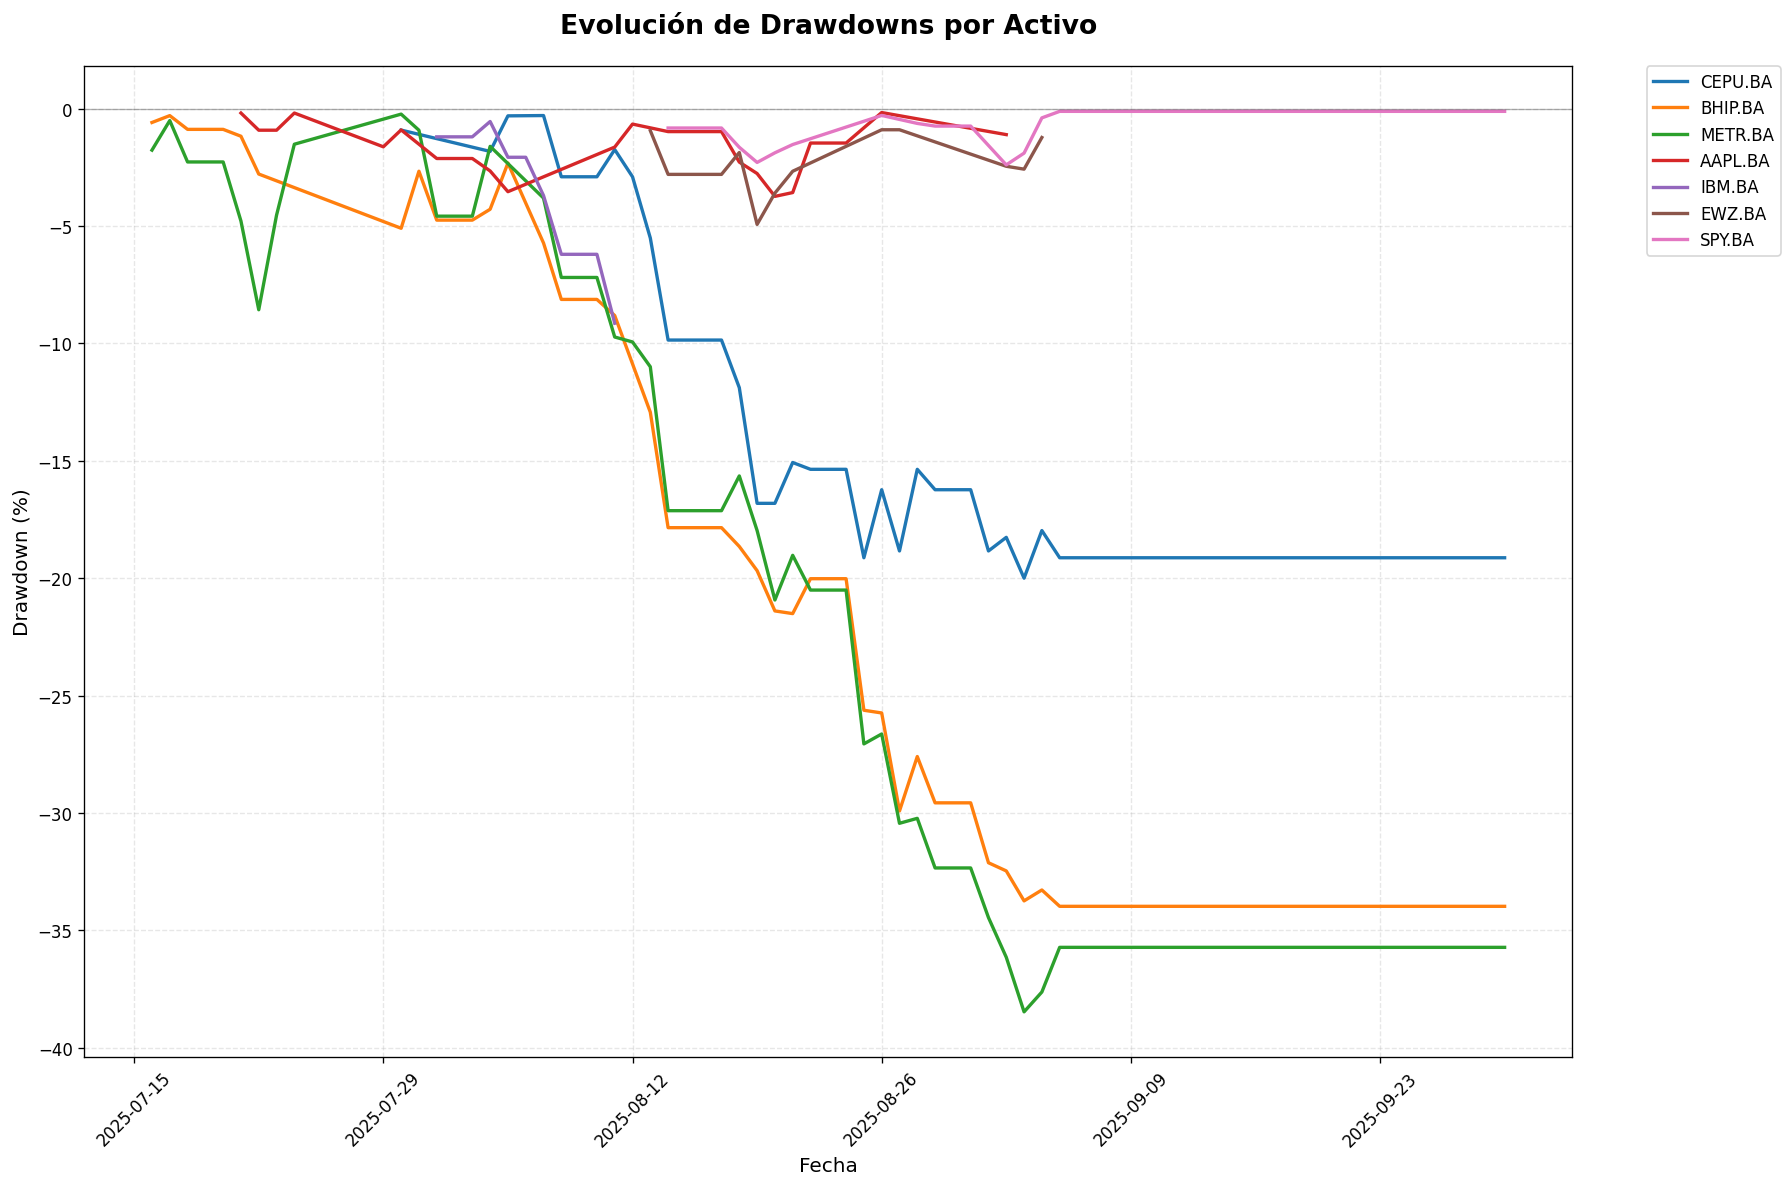

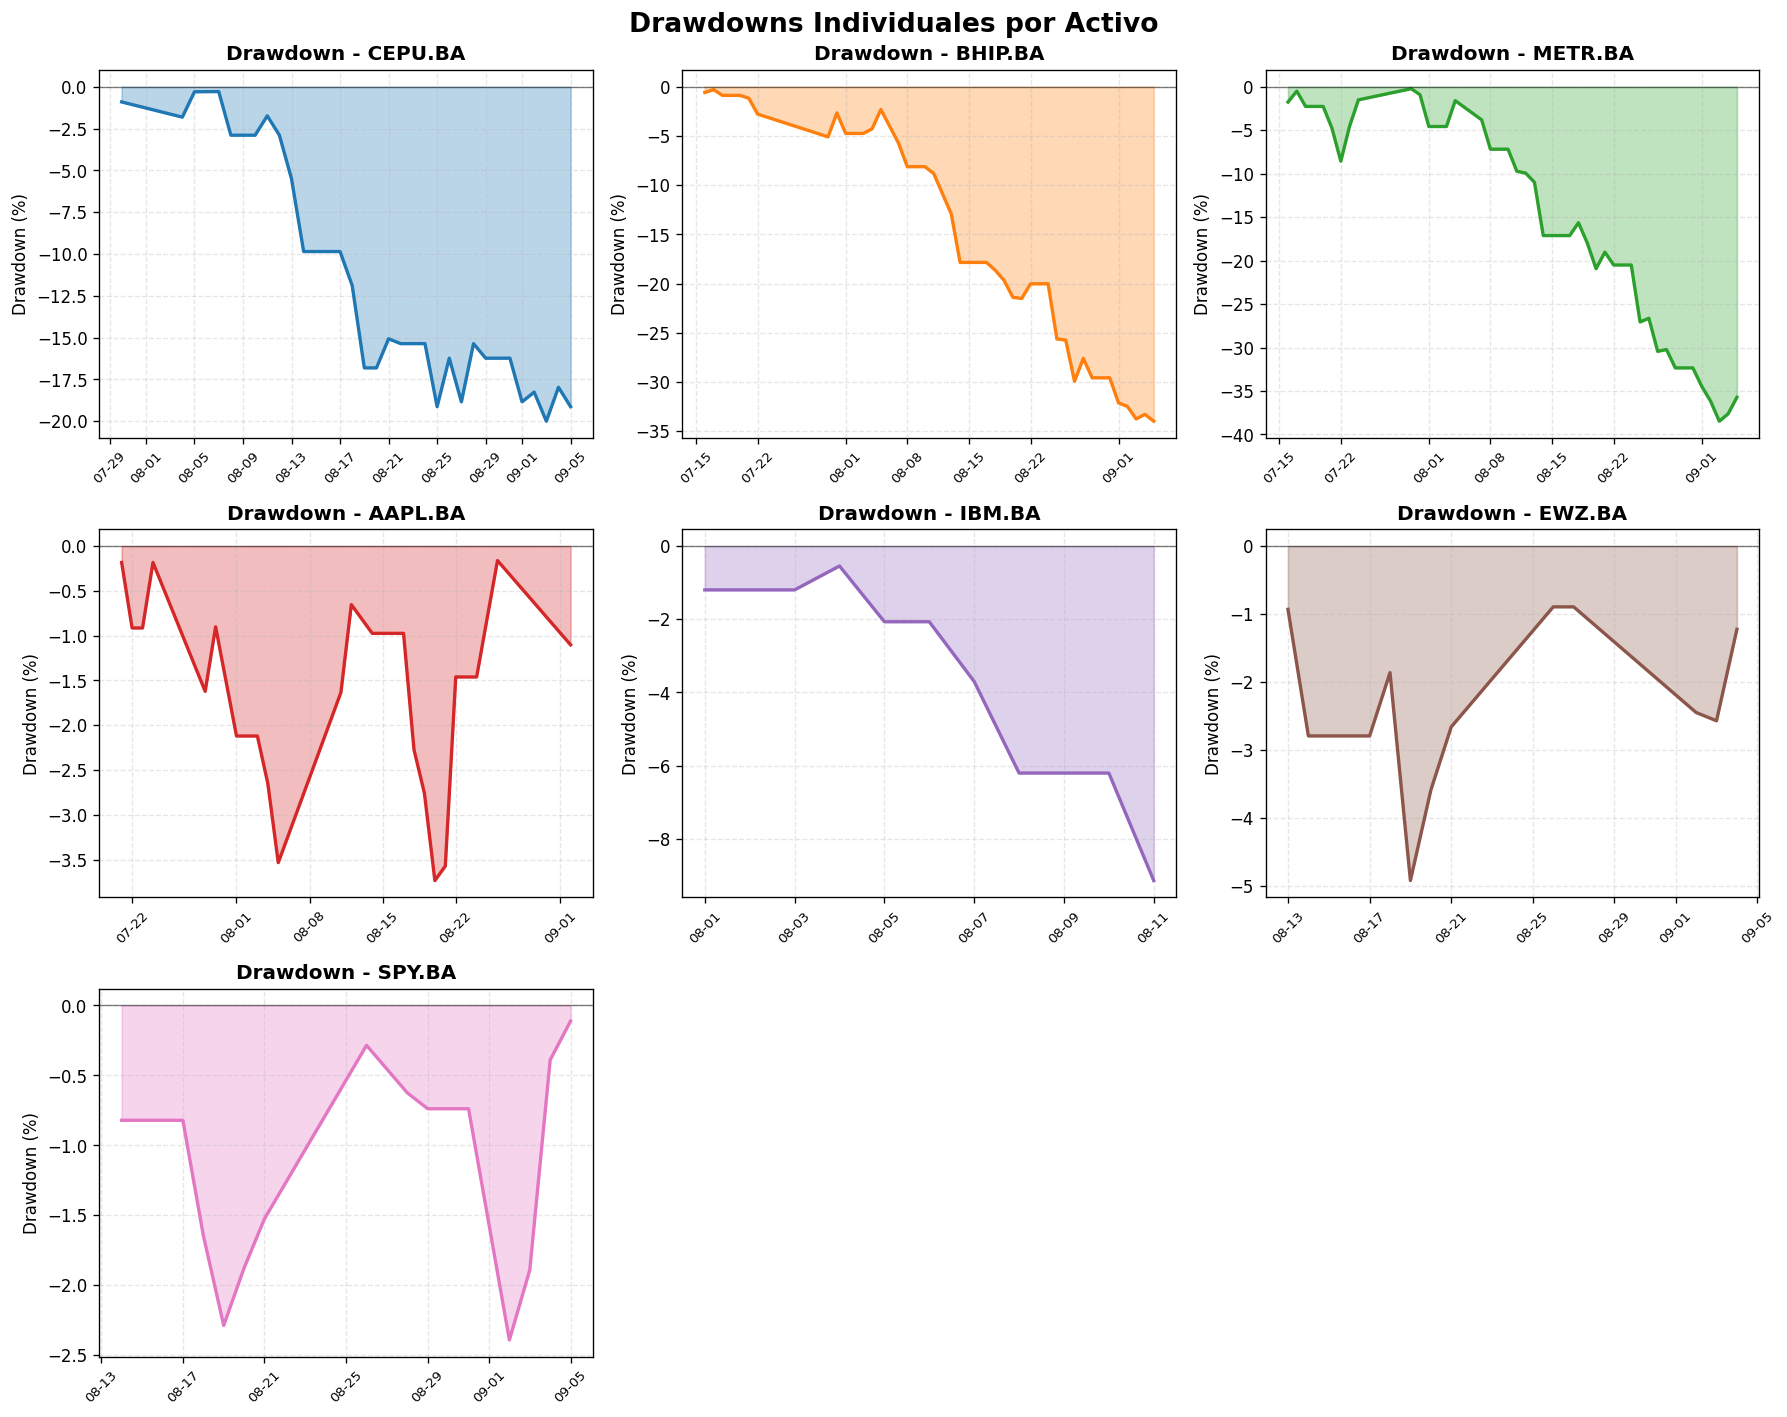


=== ESTADÍSTICAS DE DRAWDOWN ===
Símbolo    DD Máximo (%)   DD Promedio (%)    Días en DD  
------------------------------------------------------------
CEPU.BA    -20.00          -14.81             58          
BHIP.BA    -33.98          -22.09             69          
METR.BA    -38.48          -22.74             70          
AAPL.BA    -3.73           -1.59              26          
IBM.BA     -9.14           -3.61              11          
EWZ.BA     -4.93           -2.37              14          
SPY.BA     -2.39           -0.51              42          

=== RESUMEN DE POSICIONES ===
CEPU.BA: 64 días con posiciones, rango [-15, -15]
BHIP.BA: 78 días con posiciones, rango [-31, -31]
METR.BA: 78 días con posiciones, rango [-10, -10]
AAPL.BA: 78 días con posiciones, rango [2, 2]
IBM.BA: 14 días con posiciones, rango [2, 2]
EWZ.BA: 50 días con posiciones, rango [1, 1]
SPY.BA: 50 días con posiciones, rango [1, 1]


In [10]:
# Celda 6: Corrección del cálculo de drawdown y gráficos

# Función corregida para calcular drawdown
def drawdown_corrected(price_series, position_series):
    # Solo calcular drawdown cuando hay posiciones
    combined = price_series * position_series
    non_zero_mask = position_series != 0

    if not non_zero_mask.any():
        return pd.Series(0.0, index=price_series.index)

    # Tomar solo los períodos con posiciones
    active_series = combined[non_zero_mask]

    if len(active_series) == 0:
        return pd.Series(0.0, index=price_series.index)

    # Calcular el valor acumulativo (sin dividir por el primer valor si es 0)
    first_nonzero = active_series[active_series != 0].iloc[0] if (active_series != 0).any() else 1

    if first_nonzero == 0:
        return pd.Series(0.0, index=price_series.index)

    cumulative = active_series / first_nonzero
    hwm = np.maximum.accumulate(cumulative)
    dd = (cumulative - hwm) / hwm

    # Crear serie completa con ceros donde no hay posiciones
    full_dd = pd.Series(0.0, index=price_series.index)
    full_dd[non_zero_mask] = dd

    return full_dd

# Recalcular drawdowns
drawdowns_corrected = {}
for sym in SYMBOLS:
    drawdowns_corrected[sym] = drawdown_corrected(prices[sym], positions[sym])

# Verificar que tenemos datos
print("Verificando datos de drawdown:")
for sym in SYMBOLS:
    dd_data = drawdowns_corrected[sym]
    non_zero_count = (dd_data != 0).sum()
    min_dd = dd_data.min()
    max_dd = dd_data.max()
    print(f"{sym}: {non_zero_count} días con drawdown != 0, rango: [{min_dd:.4f}, {max_dd:.4f}]")

print("\n" + "="*50)

# Configurar el gráfico principal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

plt.figure(figsize=(15, 10))

# Colores para cada activo
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Graficar cada drawdown
for i, (symbol, dd_series) in enumerate(drawdowns_corrected.items()):
    # Filtrar valores no nulos y convertir a porcentaje
    dd_clean = dd_series[dd_series != 0] * 100  # Solo valores != 0

    if len(dd_clean) > 0:
        plt.plot(dd_clean.index, dd_clean.values,
                label=symbol,
                linewidth=2,
                color=colors[i % len(colors)])

# Personalizar el gráfico
plt.title('Evolución de Drawdowns por Activo', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Drawdown (%)', fontsize=12)

# Configurar el eje Y para mostrar valores negativos
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.8)

# Configurar formato de fechas en el eje X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.xticks(rotation=45)

# Añadir grilla
plt.grid(True, alpha=0.3, linestyle='--')

# Configurar la leyenda
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Ajustar layout para que la leyenda no se corte
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Opcional: También crear un gráfico con subplots individuales
plt.figure(figsize=(15, 12))

# Definir fecha límite para todos los gráficos
end_date = pd.to_datetime('2025-09-05')

n_symbols = len(SYMBOLS)
n_cols = 3
n_rows = math.ceil(n_symbols / n_cols)

for i, symbol in enumerate(SYMBOLS):
    plt.subplot(n_rows, n_cols, i + 1)

    # Filtrar por fecha y valores no nulos
    dd_series = drawdowns_corrected[symbol][(drawdowns_corrected[symbol] != 0) & (drawdowns_corrected[symbol].index <= end_date)] * 100

    if len(dd_series) > 0:
        plt.plot(dd_series.index, dd_series.values,
                color=colors[i % len(colors)],
                linewidth=2)

        # Rellenar el área bajo la curva para enfatizar las pérdidas
        plt.fill_between(dd_series.index, dd_series.values, 0,
                        alpha=0.3, color=colors[i % len(colors)])

    plt.title(f'Drawdown - {symbol}', fontsize=12, fontweight='bold')
    plt.ylabel('Drawdown (%)', fontsize=10)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)
    plt.grid(True, alpha=0.3, linestyle='--')

    # Formato de fechas más compacto para subplots
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.xticks(rotation=45, fontsize=8)

plt.suptitle('Drawdowns Individuales por Activo', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Estadísticas de drawdown
print("\n=== ESTADÍSTICAS DE DRAWDOWN ===")
print(f"{'Símbolo':<10} {'DD Máximo (%)':<15} {'DD Promedio (%)':<18} {'Días en DD':<12}")
print("-" * 60)

for symbol in SYMBOLS:
    dd_series = drawdowns_corrected[symbol]
    dd_nonzero = dd_series[dd_series != 0] * 100

    if len(dd_nonzero) > 0:
        max_dd = dd_nonzero.min()  # Mínimo porque los drawdowns son negativos
        avg_dd = dd_nonzero.mean()
        days_in_dd = (dd_nonzero < -0.1).sum()  # Días con DD > 0.1%

        print(f"{symbol:<10} {max_dd:<15.2f} {avg_dd:<18.2f} {days_in_dd:<12}")
    else:
        print(f"{symbol:<10} {'Sin posición':<15} {'Sin posición':<18} {'0':<12}")

# Mostrar también las posiciones para debug
print("\n=== RESUMEN DE POSICIONES ===")
for symbol in SYMBOLS:
    pos_nonzero = positions[symbol][positions[symbol] != 0]
    if len(pos_nonzero) > 0:
        print(f"{symbol}: {len(pos_nonzero)} días con posiciones, rango [{pos_nonzero.min():.0f}, {pos_nonzero.max():.0f}]")
    else:
        print(f"{symbol}: Sin posiciones durante el período")

Verificando datos de drawdown:
CEPU.BA: 58 días con drawdown != 0, rango: [-0.2000, 0.0000]
BHIP.BA: 69 días con drawdown != 0, rango: [-0.3398, 0.0000]
METR.BA: 70 días con drawdown != 0, rango: [-0.3848, 0.0000]
AAPL.BA: 26 días con drawdown != 0, rango: [-0.0373, 0.0000]
IBM.BA: 11 días con drawdown != 0, rango: [-0.0914, 0.0000]
EWZ.BA: 14 días con drawdown != 0, rango: [-0.0493, 0.0000]
SPY.BA: 42 días con drawdown != 0, rango: [-0.0239, 0.0000]



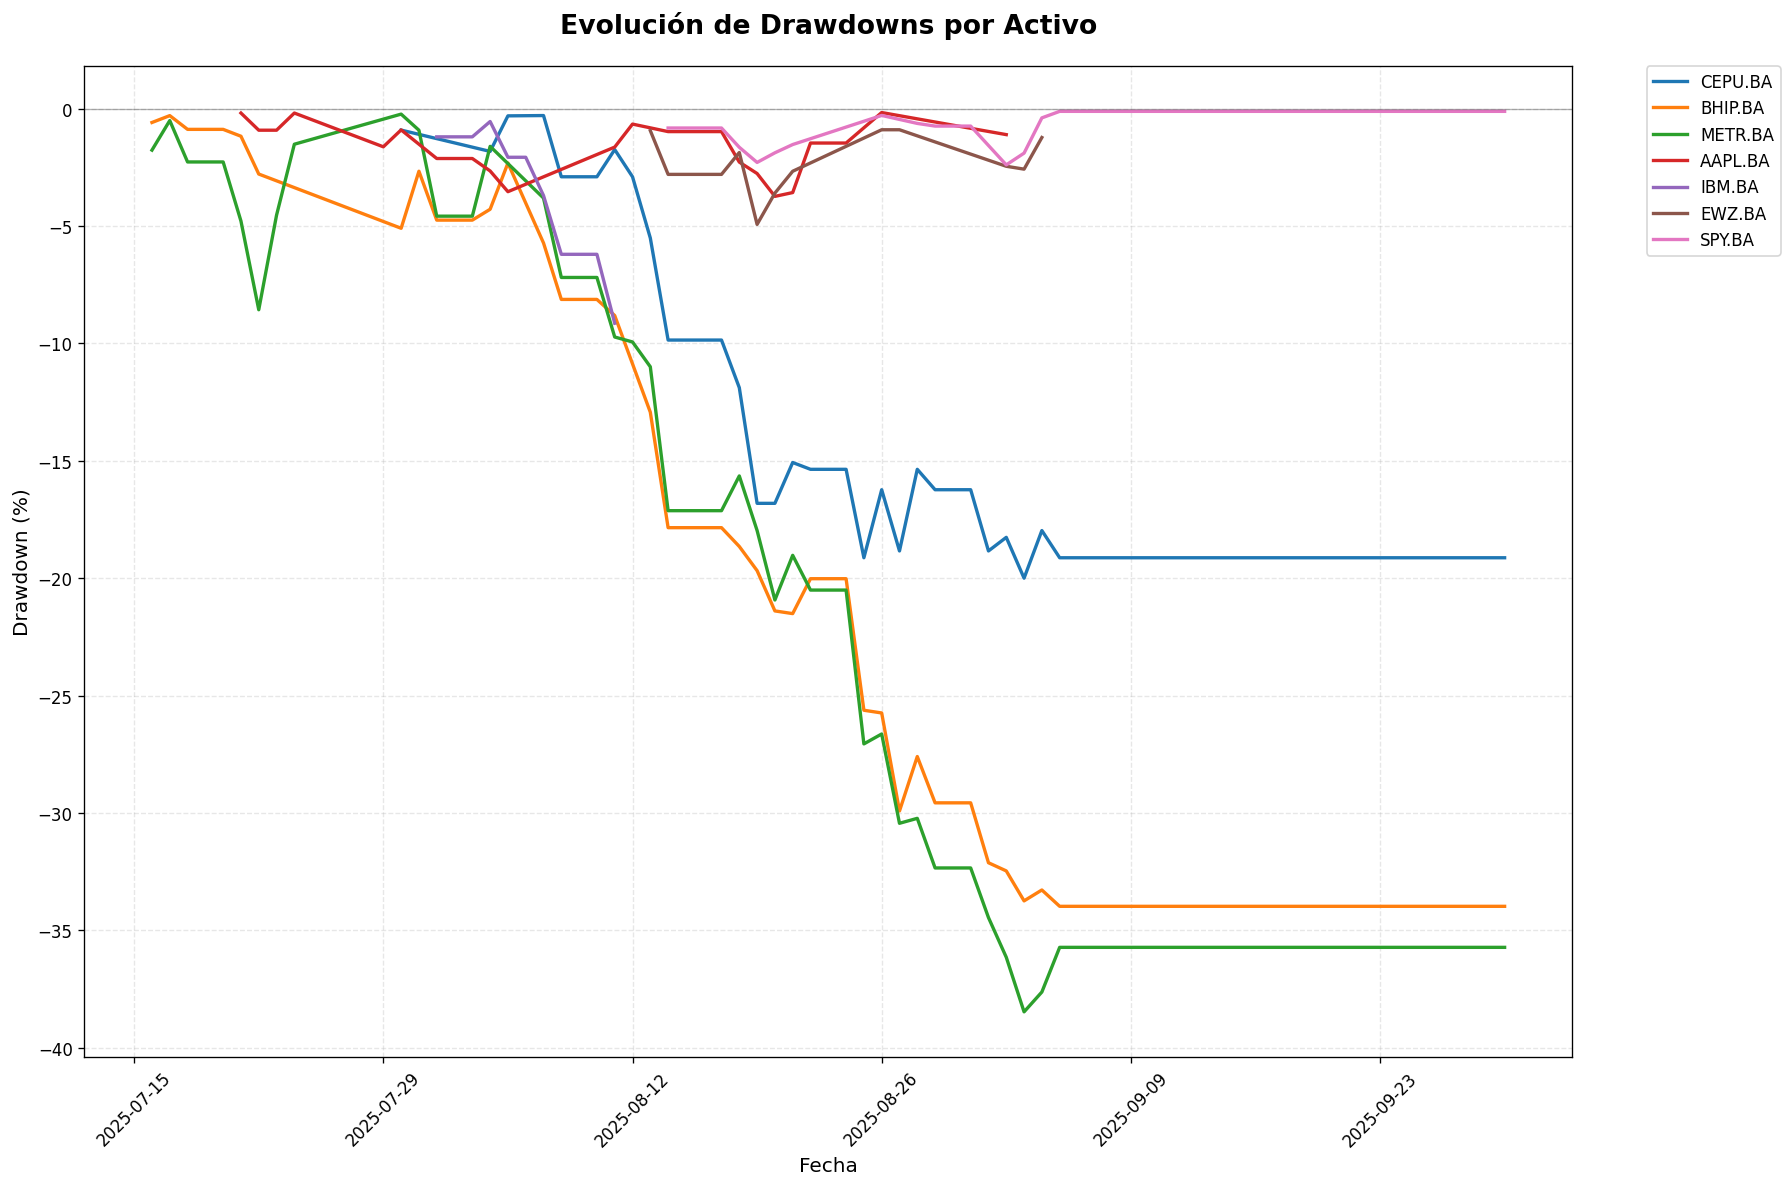

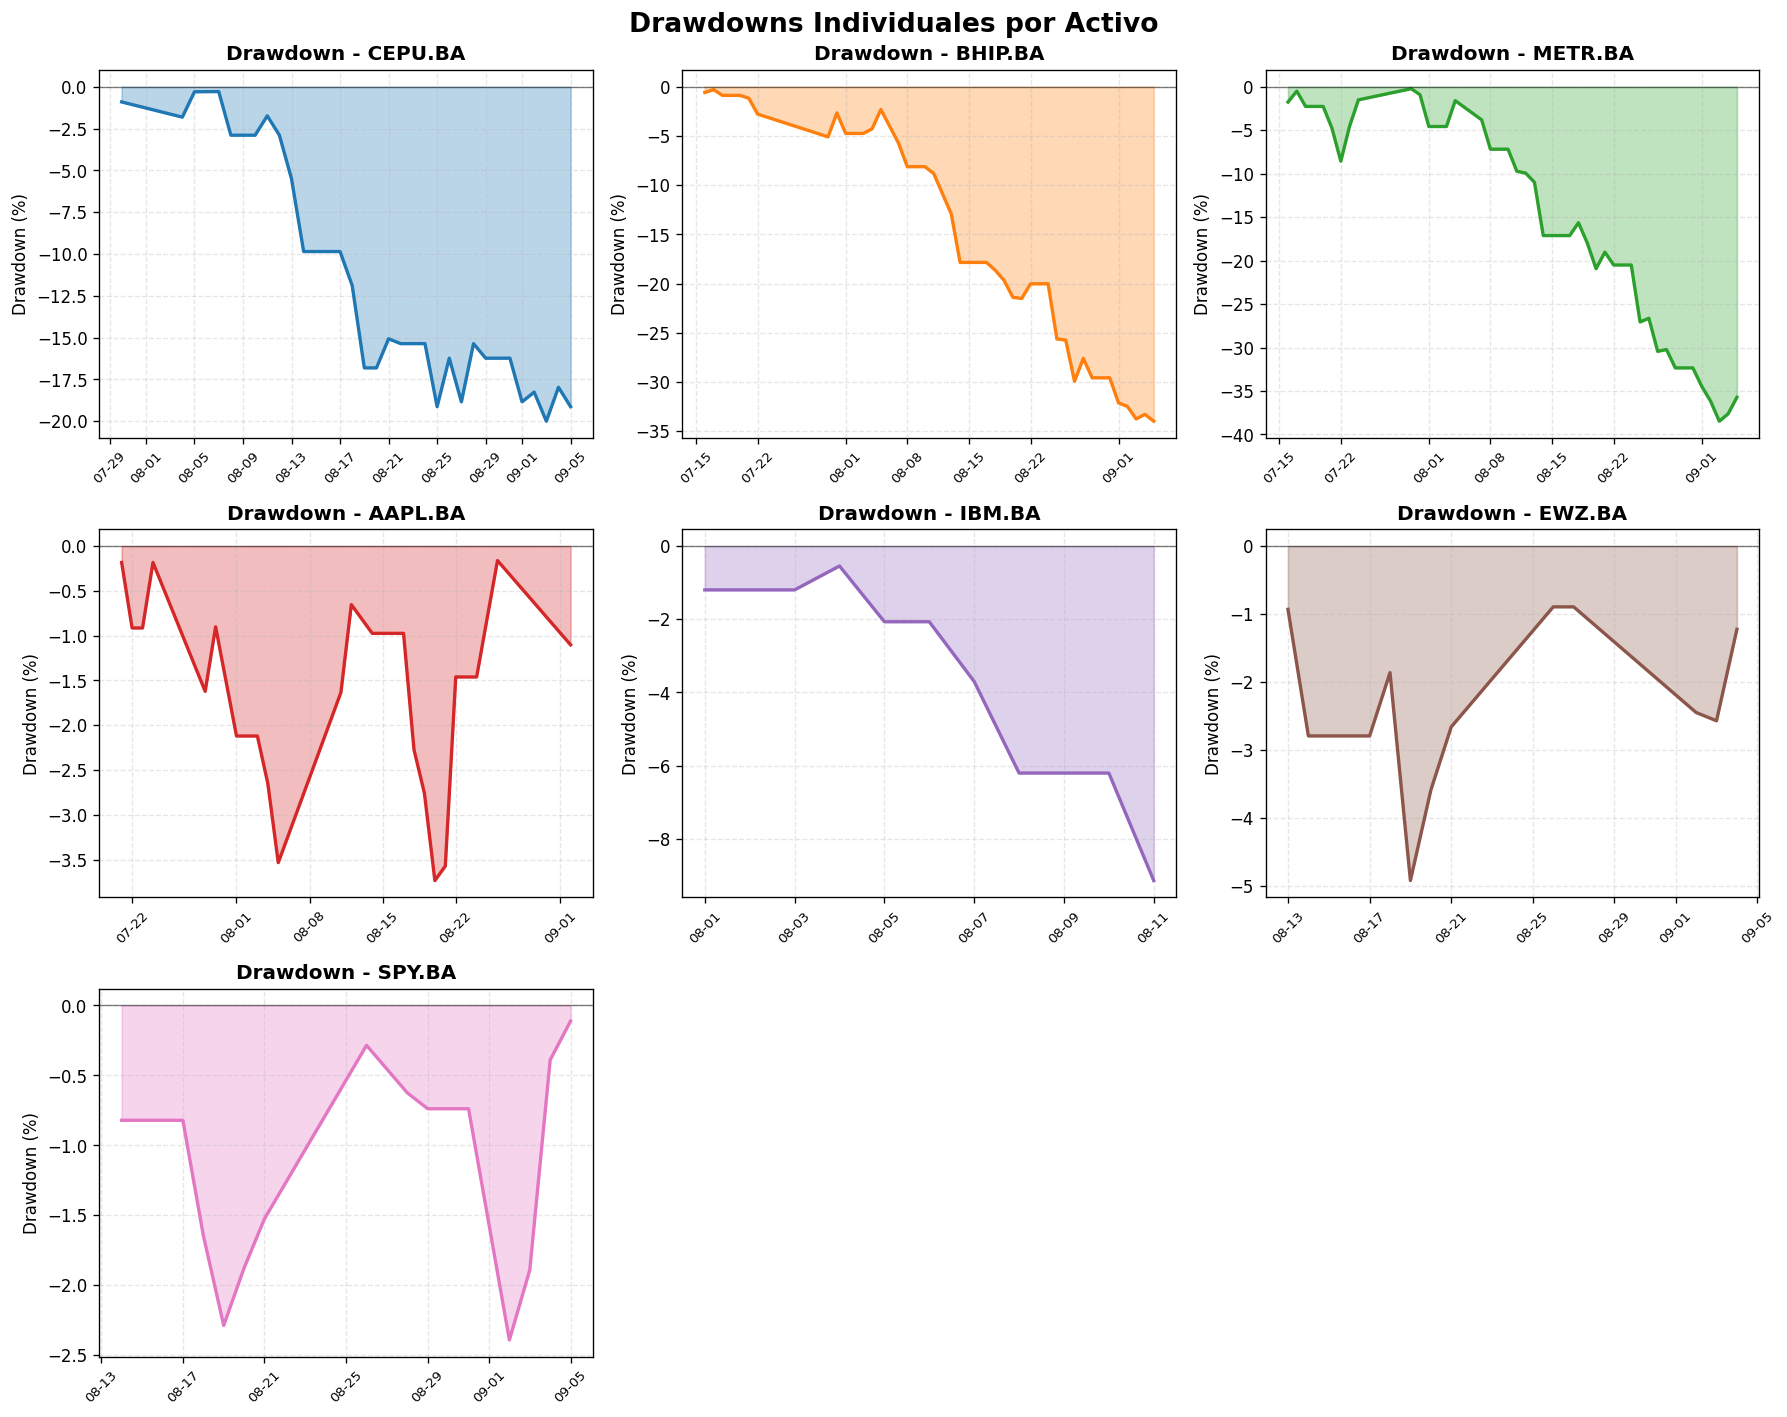

/tmp/ipython-input-4106366104.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weight_symbol = weights[symbol].fillna(0)


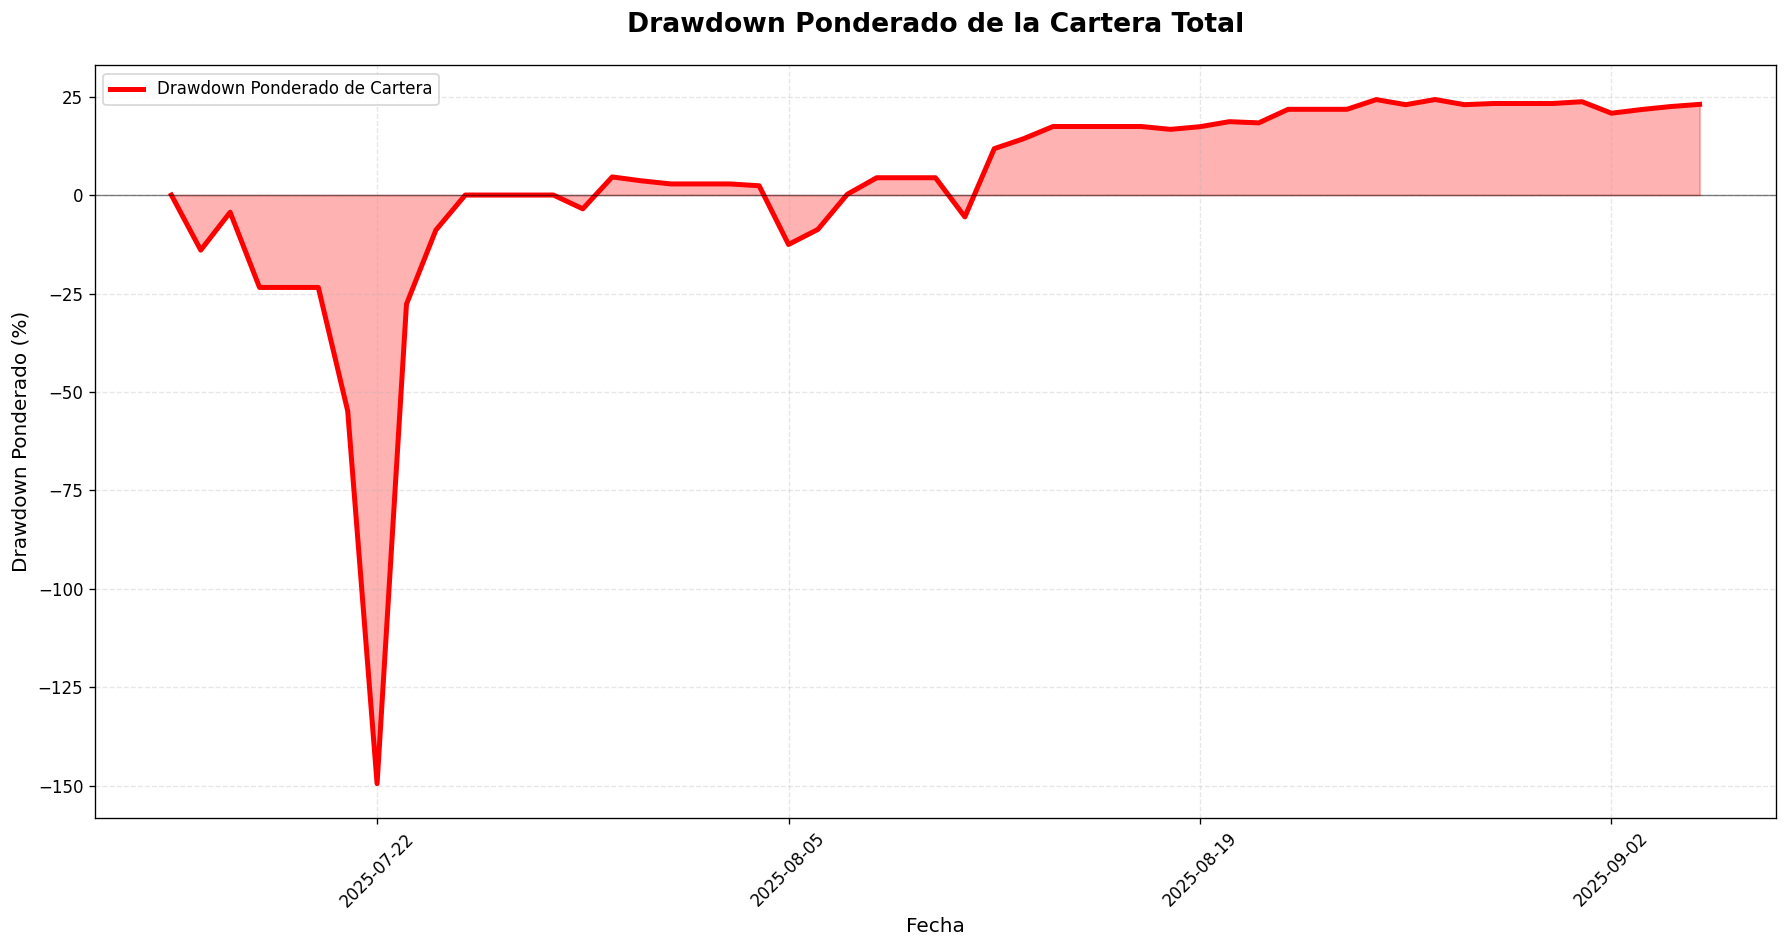


=== DRAWDOWN PONDERADO DE CARTERA ===
Drawdown máximo de cartera: -149.44%
Drawdown promedio de cartera: 3.40%
Días con drawdown: 53

=== CONTRIBUCIÓN PROMEDIO AL DRAWDOWN DE CARTERA ===
CEPU.BA: 3.897%
BHIP.BA: 2.793%
METR.BA: -0.011%
AAPL.BA: -0.227%
IBM.BA: -2.409%
EWZ.BA: -0.290%
SPY.BA: -0.355%

=== ESTADÍSTICAS DE DRAWDOWN ===
Símbolo    DD Máximo (%)   DD Promedio (%)    Días en DD  
------------------------------------------------------------
CEPU.BA    -20.00          -14.81             58          
BHIP.BA    -33.98          -22.09             69          
METR.BA    -38.48          -22.74             70          
AAPL.BA    -3.73           -1.59              26          
IBM.BA     -9.14           -3.61              11          
EWZ.BA     -4.93           -2.37              14          
SPY.BA     -2.39           -0.51              42          

=== RESUMEN DE POSICIONES ===
CEPU.BA: 64 días con posiciones, rango [-15, -15]
BHIP.BA: 78 días con posiciones, rango [-31, -31]


/tmp/ipython-input-4106366104.py:200: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weight_symbol = weights[symbol].fillna(0)


In [11]:
# Celda 6: Corrección del cálculo de drawdown y gráficos

# Función corregida para calcular drawdown
def drawdown_corrected(price_series, position_series):
    # Solo calcular drawdown cuando hay posiciones
    combined = price_series * position_series
    non_zero_mask = position_series != 0

    if not non_zero_mask.any():
        return pd.Series(0.0, index=price_series.index)

    # Tomar solo los períodos con posiciones
    active_series = combined[non_zero_mask]

    if len(active_series) == 0:
        return pd.Series(0.0, index=price_series.index)

    # Calcular el valor acumulativo (sin dividir por el primer valor si es 0)
    first_nonzero = active_series[active_series != 0].iloc[0] if (active_series != 0).any() else 1

    if first_nonzero == 0:
        return pd.Series(0.0, index=price_series.index)

    cumulative = active_series / first_nonzero
    hwm = np.maximum.accumulate(cumulative)
    dd = (cumulative - hwm) / hwm

    # Crear serie completa con ceros donde no hay posiciones
    full_dd = pd.Series(0.0, index=price_series.index)
    full_dd[non_zero_mask] = dd

    return full_dd

# Recalcular drawdowns
drawdowns_corrected = {}
for sym in SYMBOLS:
    drawdowns_corrected[sym] = drawdown_corrected(prices[sym], positions[sym])

# Verificar que tenemos datos
print("Verificando datos de drawdown:")
for sym in SYMBOLS:
    dd_data = drawdowns_corrected[sym]
    non_zero_count = (dd_data != 0).sum()
    min_dd = dd_data.min()
    max_dd = dd_data.max()
    print(f"{sym}: {non_zero_count} días con drawdown != 0, rango: [{min_dd:.4f}, {max_dd:.4f}]")

print("\n" + "="*50)

# Configurar el gráfico principal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

plt.figure(figsize=(15, 10))

# Colores para cada activo
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Graficar cada drawdown
for i, (symbol, dd_series) in enumerate(drawdowns_corrected.items()):
    # Filtrar valores no nulos y convertir a porcentaje
    dd_clean = dd_series[dd_series != 0] * 100  # Solo valores != 0

    if len(dd_clean) > 0:
        plt.plot(dd_clean.index, dd_clean.values,
                label=symbol,
                linewidth=2,
                color=colors[i % len(colors)])

# Personalizar el gráfico
plt.title('Evolución de Drawdowns por Activo', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Drawdown (%)', fontsize=12)

# Configurar el eje Y para mostrar valores negativos
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.8)

# Configurar formato de fechas en el eje X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.xticks(rotation=45)

# Añadir grilla
plt.grid(True, alpha=0.3, linestyle='--')

# Configurar la leyenda
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Ajustar layout para que la leyenda no se corte
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Opcional: También crear un gráfico con subplots individuales
plt.figure(figsize=(15, 12))

n_symbols = len(SYMBOLS)
n_cols = 3
n_rows = math.ceil(n_symbols / n_cols)

for i, symbol in enumerate(SYMBOLS):
    plt.subplot(n_rows, n_cols, i + 1)

    # Filtrar por fecha y valores no nulos
    dd_series = drawdowns_corrected[symbol][(drawdowns_corrected[symbol] != 0) & (drawdowns_corrected[symbol].index <= end_date)] * 100

    if len(dd_series) > 0:
        plt.plot(dd_series.index, dd_series.values,
                color=colors[i % len(colors)],
                linewidth=2)

        # Rellenar el área bajo la curva para enfatizar las pérdidas
        plt.fill_between(dd_series.index, dd_series.values, 0,
                        alpha=0.3, color=colors[i % len(colors)])

    plt.title(f'Drawdown - {symbol}', fontsize=12, fontweight='bold')
    plt.ylabel('Drawdown (%)', fontsize=10)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)
    plt.grid(True, alpha=0.3, linestyle='--')

    # Formato de fechas más compacto para subplots
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.xticks(rotation=45, fontsize=8)

plt.suptitle('Drawdowns Individuales por Activo', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Gráfico adicional: Drawdown ponderado de la cartera
plt.figure(figsize=(15, 8))

# Calcular el valor de cada posición día a día (hasta end_date)
portfolio_values = {}
for symbol in SYMBOLS:
    portfolio_values[symbol] = (positions[symbol] * prices[symbol]).loc[:end_date]

# Valor total de la cartera por día
total_portfolio_value = sum(portfolio_values.values())

# Calcular pesos de cada activo (solo cuando el valor total != 0)
weights = pd.DataFrame(index=total_portfolio_value.index, columns=SYMBOLS)
for symbol in SYMBOLS:
    # Evitar división por cero
    mask = total_portfolio_value != 0
    weights.loc[mask, symbol] = portfolio_values[symbol].loc[mask] / total_portfolio_value.loc[mask]
    weights.loc[~mask, symbol] = 0

# Calcular drawdown ponderado de la cartera
portfolio_drawdown = pd.Series(0.0, index=total_portfolio_value.index)

for symbol in SYMBOLS:
    dd_symbol = drawdowns_corrected[symbol].loc[:end_date]
    weight_symbol = weights[symbol].fillna(0)
    # Solo contribuye al drawdown ponderado cuando hay posiciones
    contribution = dd_symbol * weight_symbol * (positions[symbol].loc[:end_date] != 0)
    portfolio_drawdown += contribution.fillna(0)

# Filtrar solo donde hay posiciones activas
portfolio_drawdown_clean = portfolio_drawdown[total_portfolio_value != 0] * 100

if len(portfolio_drawdown_clean) > 0:
    plt.plot(portfolio_drawdown_clean.index, portfolio_drawdown_clean.values,
             color='red', linewidth=3, label='Drawdown Ponderado de Cartera')

    # Rellenar el área bajo la curva
    plt.fill_between(portfolio_drawdown_clean.index, portfolio_drawdown_clean.values, 0,
                     alpha=0.3, color='red')

plt.title('Drawdown Ponderado de la Cartera Total', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Drawdown Ponderado (%)', fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend()

# Configurar formato de fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Mostrar estadísticas del drawdown ponderado
if len(portfolio_drawdown_clean) > 0:
    max_portfolio_dd = portfolio_drawdown_clean.min()
    avg_portfolio_dd = portfolio_drawdown_clean.mean()

    print(f"\n=== DRAWDOWN PONDERADO DE CARTERA ===")
    print(f"Drawdown máximo de cartera: {max_portfolio_dd:.2f}%")
    print(f"Drawdown promedio de cartera: {avg_portfolio_dd:.2f}%")
    print(f"Días con drawdown: {len(portfolio_drawdown_clean)}")

    # Mostrar contribución promedio de cada activo al drawdown
    print(f"\n=== CONTRIBUCIÓN PROMEDIO AL DRAWDOWN DE CARTERA ===")
    for symbol in SYMBOLS:
        dd_symbol = drawdowns_corrected[symbol].loc[:end_date]
        weight_symbol = weights[symbol].fillna(0)
        contribution = (dd_symbol * weight_symbol * (positions[symbol].loc[:end_date] != 0)).fillna(0) * 100
        avg_contribution = contribution[total_portfolio_value != 0].mean()

        if abs(avg_contribution) > 0.01:  # Solo mostrar contribuciones significativas
            print(f"{symbol}: {avg_contribution:.3f}%")
else:
    print("\nNo se pudo calcular el drawdown ponderado de cartera")

# Estadísticas de drawdown
print("\n=== ESTADÍSTICAS DE DRAWDOWN ===")
print(f"{'Símbolo':<10} {'DD Máximo (%)':<15} {'DD Promedio (%)':<18} {'Días en DD':<12}")
print("-" * 60)

for symbol in SYMBOLS:
    dd_series = drawdowns_corrected[symbol]
    dd_nonzero = dd_series[dd_series != 0] * 100

    if len(dd_nonzero) > 0:
        max_dd = dd_nonzero.min()  # Mínimo porque los drawdowns son negativos
        avg_dd = dd_nonzero.mean()
        days_in_dd = (dd_nonzero < -0.1).sum()  # Días con DD > 0.1%

        print(f"{symbol:<10} {max_dd:<15.2f} {avg_dd:<18.2f} {days_in_dd:<12}")
    else:
        print(f"{symbol:<10} {'Sin posición':<15} {'Sin posición':<18} {'0':<12}")

# Mostrar también las posiciones para debug
print("\n=== RESUMEN DE POSICIONES ===")
for symbol in SYMBOLS:
    pos_nonzero = positions[symbol][positions[symbol] != 0]
    if len(pos_nonzero) > 0:
        print(f"{symbol}: {len(pos_nonzero)} días con posiciones, rango [{pos_nonzero.min():.0f}, {pos_nonzero.max():.0f}]")
    else:
        print(f"{symbol}: Sin posiciones durante el período")